In [1]:
import glob
import regex
import numpy as np
import matplotlib.pyplot as plt

In [2]:
PATH = './ustawy/'
file_names = sorted(glob.glob(PATH + "*"))
file_names[:5]

['./ustawy/1993_599.txt',
 './ustawy/1993_602.txt',
 './ustawy/1993_645.txt',
 './ustawy/1993_646.txt',
 './ustawy/1994_150.txt']

In [3]:
class LawAct:
    def __init__(self, file_name, content):
        self.file_name = file_name
        self.year = file_name.split('/')[-1].split('_')[0]
        self.content = content
        self.additions = 0
        self.removals = 0
        self.changes = 0
        
law_acts =[]
for file_name in file_names:
    with open(file_name, "r") as f:
        law_acts.append(LawAct(file_name, f.read()))

# Zadanie 1 i 2

## Dodania jednostek

Na początek wyznaczę liczbę dodanych jednostek dla każdej ustawy. Żeby przygotować odpowiedni regex najpierw wyświetlam przykładowe wystąpienia krótkiej frazy 'dodaje się' i jej otoczenia.

In [4]:
number_of_examples = 5
context_length_left = 5
context_length_right = 10

In [45]:
reg = regex.compile(r"dodaje się", regex.IGNORECASE)
law_acts_sample = np.array(law_acts)[np.random.choice(len(law_acts), number_of_examples, replace=False)]

for law_act in law_acts_sample:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        start, end = match.span()
        print(law_act.content[start - context_length_left: end + context_length_right])
        print('--------------------------')

ły wybudowane" dodaje się wyrazy "lub na
--------------------------
zenie
ust. 1 i dodaje się ust. 2-4 w brz
--------------------------
 446) w art. 6 dodaje się ust. 3 
w brzm
--------------------------

3) po art. 2a dodaje się art. 2b w brzm
--------------------------
. 4-6.",
   b) dodaje się ust. 4-7 w brz
--------------------------
  b) po ust. 3 dodaje się ust. 3a-3d w b
--------------------------
12) po art. 38 dodaje się art. 38a i 38b
--------------------------
68) po art. 14 dodaje się art. 14a i art
--------------------------
769) po
art. 8 dodaje się art. 8a i art.
--------------------------
1) po art. 35a dodaje się art. 35b i art
--------------------------
 przecinkiem i dodaje się
  wyrazy "z za
--------------------------

2)  po ust. 2 dodaje się ust. 2a w brzm
--------------------------


Otrzymane wyniki pozwalają zbudować intuicję odnośnie tego czego szukamy - szukamy wystąpień frazy oznaczającej dodawanie jednostki, po których nastepuje odpowiednie słowo/skrót oznaczające jednostkę (unit z treści zadania)

Ponadto po dokładniejszym zbadaniu zbioru dokumentów zauważyłem, że czasem frazą oznaczającą dodanie jednostki jest samo 'dodaje' np. 'dotychczasową treść oznacza się jako § 1 i dodaje § 2 w brzmieniu", a czasem niepoprawne 'dodaje sie'

Wypiszę więc wszystkie unikatowe słowa występujące po 'dodaje się' i analogicznych frazach

In [6]:
reg = regex.compile(r"dodaje\s+(si[ęe]\s+)?[\w§]+", regex.IGNORECASE)
phrases = []

for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        start, end = match.span()
        phrases.append(law_act.content[start: end].split()[-1].lower())

for phrase in np.unique(phrases):
    print(phrase)

2
2a
3
38a
4
5a
art
cyfrę
drugie
dwukropek
dwukrotnie
dział
informację
każdorazowo
kropkę
kwotę
lit
litery
lp
masę
na
nowe
nowy
oddział
odnośnik
określenie
ozna
oznaczenie
pkt
po
poz
pozycję
przecinek
punkt
rozdział
rozdziały
się
tiret
trzecie
trzykrotnie
tytuł
ust
usta
użyte
użyty
w
wraz
wyraz
wyrazy
zadanie
załącznik
zdania
zdanie
§
§1a
§2
§3
średnik


Następnie ręcznie sprawdzam kontekst dopasowań fraz zakończonych bardziej "podejrzanymi" słowami, żeby sprawdzić czy na pewno powinny pojawić się w docelowym regexie i nie wymagają dodatkowych warunków

In [7]:
reg = regex.compile(r"dodaje\s+(si[eę]\s+)?\d+", regex.IGNORECASE)

for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        start, end = match.span()
        print(law_act.content[start-5: end + 20])

  d) dodaje się  4 w brzmieniu:
      
 239 dodaje się  4 w brzmieniu:
      
  b) dodaje się  3 w brzmieniu:
      
  b) dodaje się  2 w brzmieniu:
      
  b) dodaje się  2 i 3 w brzmieniu:
  
. 46 dodaje się  3 w brzmieniu:
     "
 445 dodaje się  4 w brzmieniu:
      
 824 dodaje się   3 w brzmieniu:
    "3
 233 dodaje się  3 w brzmieniu:
     "
. 38 dodaje się 38a-38c w brzmieniu:
 
  b) dodaje się 2a w brzmieniu:
     
o  5 dodaje się  5a i  5b w brzmieniu:
 1 i dodaje  2 w brzmieniu:
     "


Analizując powyższe wyniki, po sprawdzeniu dopasowań z kontekstem, jako "addition of a unit" traktował będę frazy zawierające po 'dodaje się' (lub frazach analogicznych):
- [numer]
- art
- dział
- litery
- lit
- oddział
- pkt
- poz
- pozycję
- punkt
- rozdziały
- rozdział
- tiret
- usta
- ust
- załącznik
- §
- czasami pomiędzy 'dodaje się' a końcówką może wystąpić również słowo 'nowy' albo 'nowe'

Dodatkowo ulepszony regex powinien być odporny na niestandardowe/niepoprawne znaki białe

In [8]:
phrase_ending = r'(\d+|art|dział|litery|lit|oddział|pkt|poz|pozycję|punkt|rozdziały|rodział|tiret|usta|ust|załącznik|§)'
full_addition_regexp = r"(dodaje\s+(si[eę]\s+)?(nowy\s+|nowe\s+)?ENDING)".replace('ENDING', phrase_ending)

reg = regex.compile(full_addition_regexp, regex.IGNORECASE)

for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        law_act.additions = law_act.additions + 1
        
print("Finalna wersja użytego wyrażenia regularnego:\n", full_addition_regexp)

Finalna wersja użytego wyrażenia regularnego:
 (dodaje\s+(si[eę]\s+)?(nowy\s+|nowe\s+)?(\d+|art|dział|litery|lit|oddział|pkt|poz|pozycję|punkt|rozdziały|rodział|tiret|usta|ust|załącznik|§))


In [9]:
[law_act.additions for law_act in law_acts][:10]

[10, 1, 0, 23, 0, 2, 1, 0, 1, 0]

## Usunięcia jednostek

W analogiczny sposób wyznaczę liczbę usunięć jednostek. Żeby przygotować odpowiedni regex najpierw wyświetlam przykładowe wystąpienia krótkiej frazy 'skreśla się' i jej otoczenia.

In [10]:
number_of_examples = 5
context_length_left = 15
context_length_right = 15

In [50]:
reg = regex.compile(r"(skreśla się|uchyla się)", regex.IGNORECASE)
law_acts_sample = np.array(law_acts)[np.random.choice(len(law_acts), number_of_examples, replace=False)]

for law_act in law_acts_sample:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        start, end = match.span()
        print(law_act.content[start - context_length_left: end + context_length_right])
        print('--------------------------')

t. 4:
       - skreśla się wyrazy "przez 
--------------------------

11) w art. 17 skreśla się ust. 3;
12) w 
--------------------------
   a) w ust. 1 skreśla się wyrazy "(wykup
--------------------------
ostek.",
   c) skreśla się ust. 3 i 4;
3)
--------------------------
     - w pkt 4 skreśla się wyrazy "oraz s
--------------------------
ania,",
     - skreśla się pkt 8,
     - 
--------------------------
    - w pkt 10 skreśla się wyrazy "oraz d
--------------------------
igacji",
   b) skreśla się ust. 2 i 3;
4)
--------------------------

   b) w pkt 3 skreśla się wyraz "serie,"
--------------------------
 wypłat.";
12) skreśla się art. 17;
13) a
--------------------------
owego.",
   e) skreśla się ust. 8;
15) ar
--------------------------
ligacji.";
20) skreśla się art. 27;
21) a
--------------------------
łącznie.";
29) skreśla się art. 42;
30) p
--------------------------
t. 99 w ust. 2 skreśla się wyrazy "towarz
--------------------------
 dźwięku.”;
4) uchyla się art.
159

Szukamy więc takich wystąpień fraz oznaczających usuwanie jednostek, po których wystąpią skróty/słowa oznaczające jednostki (unit z treści zadania)

Ponadto po zbadaniu zbioru dokumentów wykryłem, że oprócz wyrażenia 'skreśla się' używane jest w niektórych przypadkach wyrażenie 'uchyla się'. Tym razem nigdzie nie występują błędnie napisane frazy z e zamiast ę na końcu. Zdarza się jednak, że podobnie jak w przypadku dodawania po frazie 'skreśla' nie występuje się.

Teraz wypiszę wszystkie słowa występujące po 'skreśla się' i analogicznych frazach

In [12]:
reg = regex.compile(r"(skreśla|uchyla)(\s+się)?\s+[\w§]+", regex.IGNORECASE)
phrases = []

for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        start, end = match.span()
        phrases.append(law_act.content[start: end].split()[-1].lower())

for phrase in np.unique(phrases):
    print(phrase)

1
11
aplikanta
art
biegłego
decyzje
decyzję
diagnostę
drugie
dział
go
i
je
jeden
jego
ją
karę
kropkę
lekarza
lit
lub
na
nakaz
niezwłocznie
od
oddział
odnośnik
odpowiednio
odpowiedzialności
oraz
orzeczenie
ostatnie
oznaczenie
pilota
pkt
poprzednią
postanowienia
postanowienie
powołanie
poz
pozostałe
pozostałą
prawomocnego
preambułę
przecinek
przepisy
przyimek
psychologa
pytania
rozdział
rozdziały
rozporządzenie
rzeczoznawcę
się
skutków
sprzeczną
ten
tiret
to
tytuł
uchwały
uchwałę
ust
ustawę
użyte
użyty
w
ważność
wszystkie
wydane
wyraz
wyrazy
wyrok
z
zabezpieczenie
zajęcie
zakaz
zakład
zarządzenie
zaskarżone
zaskarżony
zaskarżoną
zastrzeżenie
załącznik
zdania
zdanie
zezwolenie
§


Ręcznie sprawdzam kontekst dopasowań fraz zakończonych bardziej "podejrzanymi" słowami, żeby sprawdzić czy na pewno powinny pojawić się w docelowym regexie i nie wymagają dodatkowych warunków

In [13]:
reg = regex.compile(r"(skreśla|uchyla)(\s+się)?\s+w ", regex.IGNORECASE)

for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        start, end = match.span()
        print(law_act.content[start: end+80])

skreśla się w ust. 1 pkt 5,
       b) skreśla się ust. 3;
    2) w art. 57 w ust. 1 pkt 14 otr
uchyla się w okresie próby od wykonania obowiązku
            zapłacenia uszczuplonej należno
skreśla się w dziale pierwszym{ }rozdział III;
22) w art. 22:
       a) § 1 otrzymuje brzmieni
skreśla się w powołaniu wyrazy "i 477{3}-477{5}";
63) art. 477{8} otrzymuje brzmienie:
       
skreśla się w pkt 13 lit. b w pkt 1.
                                Art. 4.
Ustawa wchodzi w 
uchyla w całości lub w części. 
 § 2. Uchylając zaskarżone orzeczenie Sąd Najwyższy przek
Uchyla się w szczególności ustawę z dnia 19 kwietnia 1969 r. - Kodeks 
     postępowania karn
uchyla w całości lub w części i w tym
                    zakresie wniosek oddala bądź od
uchyla w całości lub w części decyzję dotychczasową, gdy stwierdzi istnienie
     przesła


Analizując powyższe wyniki jako "removal of a unit" traktował będę frazy zawierające po 'skreśla się' (lub frazie analogicznej):
- [numer]
- art
- dział
- lit
- oddział
- pkt
- poz (ale nie pozostałą - wystarczy zmatchować poz\.)
- preambułę
- rozdziały
- rozdział
- ust
- 'w ust', 'w dziale', 'w pkt'
- załącznik
- §

Dodatkowo ulepszony regex powinien być odporny na niestandardowe/niepoprawne znaki białe

In [14]:
phrase_ending = r'(\d+|art|dział|lit|oddział|pkt|poz\.|preambułę|rodziały|rozdział|ust|w ust|w dziale|w pkt|załącznik|§)'
full_removal_regexp = r"((skreśla|uchyla)(\s+się)?\s+ENDING)".replace('ENDING', phrase_ending)

reg = regex.compile(full_removal_regexp, regex.IGNORECASE)

for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        law_act.removals = law_act.removals + 1
print("Finalna wersja użytego wyrażenia regularnego:\n", full_removal_regexp)

Finalna wersja użytego wyrażenia regularnego:
 ((skreśla|uchyla)(\s+się)?\s+(\d+|art|dział|lit|oddział|pkt|poz\.|preambułę|rodziały|rozdział|ust|w ust|w dziale|w pkt|załącznik|§))


In [15]:
[law_act.removals for law_act in law_acts][:10]

[1, 0, 0, 4, 1, 1, 0, 0, 0, 0]

## Zmiany jednostek

W analogiczny sposób wyznaczę liczbę zmian jednostek. Żeby przygotować odpowiedni regex najpierw wyświetlam przykładowe wystąpienia krótkiej frazy 'otrzymuje brzmienie' i jej otoczenia.

In [16]:
number_of_examples = 5
context_length_left = 15
context_length_right = 15

In [52]:
reg = regex.compile(r"otrzymuje brzmienie", regex.IGNORECASE)
law_acts_sample = np.array(law_acts)[np.random.choice(len(law_acts), number_of_examples, replace=False)]

for law_act in law_acts_sample:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        start, end = match.span()
        print(law_act.content[start - context_length_left: end + context_length_right])
        print('--------------------------')

) tytuł ustawy otrzymuje brzmienie:
    "o utworz
--------------------------
:
   a) ust. 1 otrzymuje brzmienie:
     "1. Twor
--------------------------
,
   c) ust. 4 otrzymuje brzmienie:
     "4. Prez
--------------------------
u.";
3) art. 2 otrzymuje brzmienie:
     "Art. 2.
--------------------------
tu";
5) art. 4 otrzymuje brzmienie:
     "Art. 4.
--------------------------
w.";
6) art. 6 otrzymuje brzmienie:
       "Art. 
--------------------------
.";
2) art. 25 otrzymuje brzmienie:
      "Art. 2
--------------------------
";
3) art. 26b otrzymuje brzmienie:
     "Art. 26
--------------------------
ny:
 1) art. 7 otrzymuje brzmienie:
    "Art. 7. 
--------------------------
";
 2) art. 60 otrzymuje brzmienie:
   "Art. 60. 
--------------------------


Szukamy więc takich wystąpień frazy 'otrzymuje brzmienie', które poprzedzone są słowami zawierającymi oznaczenie jednostki (unit z treści zadania) która jest zmieniana. Oznaczenie to występuje w jednym z 2 słów poprzedzających wystąpienie frazy.

Ponadto inne znalezione frazy oznaczające zmiany jednostek to 'nadać brzmienie' oraz 'otrzymują brzmienie'.

Wyszukajmy więc unikatowe dwójki słów występujących przed 'otrzymuje brzmienie' i frazami analogicznymi

In [56]:
reg = regex.compile(r"[\w§1-9\.]+\s+[\w§1-9\.]+\s+(otrzymuj[eą]|nadać)\s+brzmienie", regex.IGNORECASE)
phrases = []

for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        start, end = match.span()
        phrases.append(" ".join(law_act.content[start: end].split()[:2]).lower())

for phrase in np.unique(phrases)[:10]:
    print(phrase)
# w sprawozdaniu nie wrzycam wszstkich wyników tej komórki, tylko pierwsze 10

12 załącznika
120 §6
123 2
14 ust.2
2 ust.1
22 tiret
22 ust.3
24 ust.5
26 2
30 c


Ręcznie sprawdzam kontekst dopasowań fraz poprzedzonych bardziej "podejrzanymi" słowami, żeby sprawdzić czy na pewno powinny pojawić się w docelowym regexie i nie wymagają dodatkowych warunków. Tym razem dodatkowo sprawdzam słowa występujące bezpośrednio przed frazą kluczową i drugie słowa przed frazą kluczową.

In [53]:
# reg = regex.compile(r"\btiret\s+(otrzymuj[eą]|nadać)\s+brzmienie", regex.IGNORECASE)
reg = regex.compile(r"\bust\s+[\w§1-9\.]+\s+(otrzymuj[eą]|nadać)\s+brzmienie", regex.IGNORECASE)
phrases = []

for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        start, end = match.span()
        print(law_act.content[start-15: end])

 11) w art. 18 ust 1 otrzymuje brzmienie
art. 28:
   a) ust 3 otrzymuje brzmienie
art. 19:
   a) ust 1 otrzymuje brzmienie
 136) w art. 3 ust 1a otrzymuje brzmienie
;
2) w art. 45 ust 3 otrzymuje brzmienie
art. 12:
   a) ust 2 otrzymuje brzmienie

19) w art. 49 ust 1 otrzymuje brzmienie
;
14) art. 39. ust 3 otrzymuje brzmienie
art. 37:
   a) ust 3 otrzymuje brzmienie


Analizując powyższe wyniki jako "change of a unit" traktował będę:
- frazy zawierające jako 1. "słowo" przed frazą "otrzymuje brzmienie" (lub analogiczną) jedno z poniższych:
    - tiret
    - ust.[numer]
    - §[numer]

- frazy zawierające jako 2. "słowo" przed frazą "otrzymuje brzmienie" (lub analogiczną) jedno z poniższych:
    - art 
    - art. 
    - art.[numer]
    - dział
    - i
    - lit.
    - oddział
    - pkt
    - poz.
    - rozdział
    - tiret
    - ust
    - ust.
    - §

Dodatkowo ulepszony regex powinien być odporny na niestandardowe/niepoprawne znaki białe

In [20]:
previous_word = r"(tiret|ust\.\d+|§\d+)"
second_previous_word = r"(art|art\.|art\.\d+|dział|i|lit\.|oddział|pkt|poz\.|rozdział|tiret|ust|ust\.|§)\s+[\w§1-9\.]+"
final_change_regex = r"\s+(PREV|SECOND)\s+(otrzymuj[eą]|nadać)\s+brzmienie".replace('PREV', previous_word).replace('SECOND', second_previous_word)

reg = regex.compile(final_change_regex, regex.IGNORECASE)

for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        law_act.changes = law_act.changes + 1
print("Finalna wersja użytego wyrażenia regularnego:\n", final_change_regex)

Finalna wersja użytego wyrażenia regularnego:
 \s+((tiret|ust\.\d+|§\d+)|(art|art\.|art\.\d+|dział|i|lit\.|oddział|pkt|poz\.|rozdział|tiret|ust|ust\.|§)\s+[\w§1-9\.]+)\s+(otrzymuj[eą]|nadać)\s+brzmienie


In [21]:
[law_act.changes for law_act in law_acts][:10]

[19, 9, 0, 35, 1, 1, 0, 0, 2, 0]

# Zadanie 3

In [22]:
years = np.unique([law_act.year for law_act in law_acts])
additions = {year: 0 for year in years}
removals = {year: 0 for year in years}
changes = {year: 0 for year in years}
combined_amendments = {year: 0 for year in years}

for law_act in law_acts:
    additions[law_act.year] += law_act.additions
    removals[law_act.year] += law_act.removals
    changes[law_act.year] += law_act.changes
    combined_amendments[law_act.year] += law_act.additions + law_act.removals + law_act.changes
    
additions_percentage = 100 * np.array(list(additions.values())) / np.array(list(combined_amendments.values()))
removals_percentage = 100 * np.array(list(removals.values())) / np.array(list(combined_amendments.values()))
changes_percentage = 100 * np.array(list(changes.values())) / np.array(list(combined_amendments.values()))
additions_percentage + removals_percentage + changes_percentage

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100.])

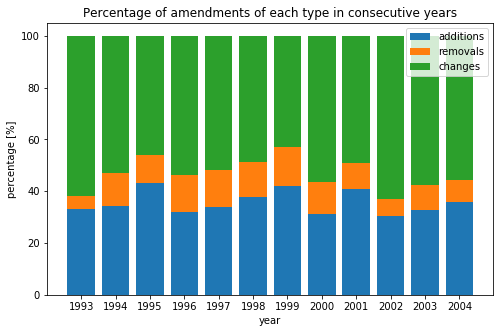

In [23]:
plt.figure(figsize=(8, 5))
plt.bar(years, additions_percentage, label='additions')
plt.bar(years, removals_percentage, bottom=additions_percentage, label='removals')
plt.bar(years, changes_percentage, bottom=additions_percentage + removals_percentage, label='changes')
plt.legend()
plt.title('Percentage of amendments of each type in consecutive years')
plt.xlabel('year')
plt.ylabel('percentage [%]')
plt.show()

# Zadanie 4

In [24]:
declination = r"\bustaw(ami|ach|om|y|o|ą|ę|ie|a)?\b"

In [25]:
reg = regex.compile(declination, regex.IGNORECASE)

occurences = 0
matches = []
for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        occurences += 1
        start, end = match.span()
        matches.append(law_act.content[start: end])
        
print(np.unique(matches))
print('Number of occurences of the word \'ustawa\' in any form', occurences)

['USTAWA' 'USTAWY' 'USTAWa' 'Ustaw' 'Ustawa' 'Ustawie' 'Ustawy' 'Ustawę'
 'ustaw' 'ustawA' 'ustawa' 'ustawach' 'ustawami' 'ustawie' 'ustawom'
 'ustawy' 'ustawą' 'ustawę']
Number of occurences of the word 'ustawa' in any form 25092


# Zadanie 5

W poniższych regexach używam positive/negative lookahead

In [26]:
reg = regex.compile(r"DEC(?=\s+z\s+dnia\b)".replace('DEC', declination), regex.IGNORECASE)

followed_occurences = 0
followed_matches = []
for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        followed_occurences += 1
        start, end = match.span()
        followed_matches.append(law_act.content[start: end])
        
print(np.unique(followed_matches))
print('Number of occurences of the word \'ustawa\' in any form followed by \'z dnia\' expression', followed_occurences)

['USTAWA' 'USTAWa' 'Ustawa' 'Ustawy' 'ustawA' 'ustawa' 'ustawach'
 'ustawie' 'ustawy' 'ustawą' 'ustawę']
Number of occurences of the word 'ustawa' in any form followed by 'z dnia' expression 8638


# Zadanie 6

In [27]:
reg = regex.compile(r"DEC(?!\s+z\s+dnia\b)".replace('DEC', declination), regex.IGNORECASE)

not_followed_occurences = 0
not_followed_matches = []
for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        not_followed_occurences += 1
        start, end = match.span()
        not_followed_matches.append(" ".join(law_act.content[start: end].split()))
        
print(np.unique(not_followed_matches))
print('Number of occurences of the word \'ustawa\' in any form NOT followed by \'z dnia\' expression', not_followed_occurences)

['USTAWA' 'USTAWY' 'Ustaw' 'Ustawa' 'Ustawie' 'Ustawy' 'Ustawę' 'ustaw'
 'ustawa' 'ustawach' 'ustawami' 'ustawie' 'ustawom' 'ustawy' 'ustawą'
 'ustawę']
Number of occurences of the word 'ustawa' in any form NOT followed by 'z dnia' expression 16454


Sprawdźmy, czy liczba matchów się zgadza, czyli:

(wynik zadania 5) + (wynik zadania 6) = (wynik zadania 4)

In [28]:
occurences

25092

In [29]:
followed_occurences + not_followed_occurences

25092

In [30]:
followed_occurences + not_followed_occurences == occurences

True

# Zadanie 7

W poniższych regexach używam positive/negative lookbehind

In [31]:
reg = regex.compile(r"(?<!\bo\s+zmianie\s+)DEC".replace('DEC', declination), regex.IGNORECASE)

not_preceded_occurences = 0
not_preceded__matches = []
for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        not_preceded_occurences += 1
        start, end = match.span()
        not_preceded__matches.append(" ".join(law_act.content[start: end].split()))
        
print(np.unique(not_preceded__matches))
print('Number of occurences of the word \'ustawa\' in any form NOT preceded by \'o zmianie\' expression', not_preceded_occurences)

['USTAWA' 'USTAWY' 'USTAWa' 'Ustaw' 'Ustawa' 'Ustawie' 'Ustawy' 'Ustawę'
 'ustaw' 'ustawA' 'ustawa' 'ustawach' 'ustawami' 'ustawie' 'ustawom'
 'ustawy' 'ustawą' 'ustawę']
Number of occurences of the word 'ustawa' in any form NOT preceded by 'o zmianie' expression 24226


In [32]:
reg = regex.compile(r"(?<=\bo\s+zmianie\s+)DEC".replace('DEC', declination), regex.IGNORECASE)

preceded_occurences = 0
preceded__matches = []
for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        preceded_occurences += 1
        start, end = match.span()
        preceded__matches.append(" ".join(law_act.content[start: end].split()))
        
print(np.unique(preceded__matches))
print('Number of occurences of the word \'ustawa\' in any form preceded by \'o zmianie\' expression', preceded_occurences)

['Ustawy' 'ustaw' 'ustawy']
Number of occurences of the word 'ustawa' in any form preceded by 'o zmianie' expression 866


Sprawdźmy, czy liczba matchów się zgadza, czyli liczba wystąpień nie poprzedzonych wyrażeniem o zmianie zsumowana z liczbą wystąpień poprzedzonych tym wyrażeniem daje nam sumaryczną liczbę wystąpień słowa ustawa w dodowlnej formie

In [33]:
occurences

25092

In [34]:
preceded_occurences + not_preceded_occurences

25092

In [35]:
preceded_occurences + not_preceded_occurences == occurences

True

# Zadanie 8

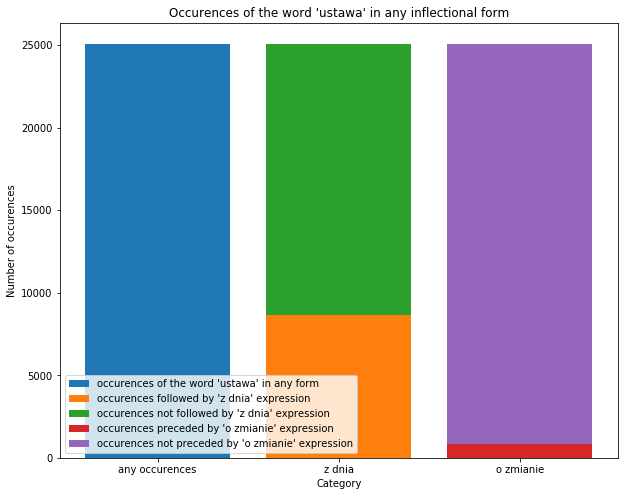

In [36]:
plt.figure(figsize=(10, 8))
plt.bar("any occurences", occurences, label="occurences of the word 'ustawa' in any form")

plt.bar("z dnia", followed_occurences, label="occurences followed by 'z dnia' expression")
plt.bar("z dnia", not_followed_occurences, bottom=followed_occurences, label="occurences not followed by 'z dnia' expression")

plt.bar("o zmianie", preceded_occurences, label="occurences preceded by 'o zmianie' expression")
plt.bar("o zmianie", not_preceded_occurences, bottom=preceded_occurences, label="occurences not preceded by 'o zmianie' expression")

plt.legend(loc=3)
plt.title("Occurences of the word 'ustawa' in any inflectional form")
plt.xlabel('Category')
plt.ylabel('Number of occurences')
plt.show()